# 🔥 Fraud Detection Pipeline - Local GPU Training

**Optimized for local GPU execution with 1.4M+ records**

This notebook is configured for:
- Local file loading (no Colab dependencies)
- GPU-accelerated training for XGBoost and CatBoost
- Hyperparameter tuning with Optuna
- Comprehensive model evaluation

## Section 1: GPU Verification & Setup

In [1]:
# Verify GPU availability
import subprocess
import sys

print("🔍 Checking GPU availability...")
print("="*60)

# Check NVIDIA GPU
try:
    result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
    if result.returncode == 0:
        print("✅ NVIDIA GPU detected!")
        # Print GPU info
        lines = result.stdout.split('\n')
        for line in lines[:12]:
            print(line)
    else:
        print("⚠️ nvidia-smi failed. GPU may not be available.")
except FileNotFoundError:
    print("❌ nvidia-smi not found. NVIDIA drivers may not be installed.")

print("\n" + "="*60)

🔍 Checking GPU availability...
✅ NVIDIA GPU detected!
Thu Feb  5 11:05:07 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 591.86                 Driver Version: 591.86         CUDA Version: 13.1     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:02:00.0 Off |                  N/A |
| N/A   50C    P0             11W /   70W |       0MiB /   6144MiB |      0%      Default |
|                                         |                        |                  

In [2]:
# Verify XGBoost GPU support
import xgboost as xgb

print(f"XGBoost version: {xgb.__version__}")

# Test GPU availability for XGBoost
try:
    import numpy as np
    test_data = xgb.DMatrix(np.random.randn(100, 10))
    params = {'device': 'cuda', 'tree_method': 'hist'}
    xgb.train(params, test_data, num_boost_round=1)
    print("✅ XGBoost GPU (CUDA) support: Available")
    XGBOOST_GPU = True
except Exception as e:
    print(f"⚠️ XGBoost GPU not available: {e}")
    print("   Will fall back to CPU training.")
    XGBOOST_GPU = False

XGBoost version: 3.1.3
⚠️ XGBoost GPU not available: [11:05:22] C:\actions-runner\_work\xgboost\xgboost\src\objective\init_estimation.h:22: Check failed: info.labels.Shape(0) == info.num_row_ (0 vs. 100) : Invalid shape of labels.
   Will fall back to CPU training.


In [3]:
# Verify CatBoost GPU support
from catboost import CatBoostClassifier
import catboost

print(f"CatBoost version: {catboost.__version__}")

try:
    test_model = CatBoostClassifier(iterations=1, task_type='GPU', verbose=False)
    test_model.fit(np.random.randn(100, 10), np.random.randint(0, 2, 100))
    print("✅ CatBoost GPU support: Available")
    CATBOOST_GPU = True
except Exception as e:
    print(f"⚠️ CatBoost GPU not available: {e}")
    print("   Will fall back to CPU training.")
    CATBOOST_GPU = False

CatBoost version: 1.2.8
✅ CatBoost GPU support: Available


## Section 2: Import Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    recall_score, precision_score, f1_score
)
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import optuna
from tqdm import tqdm
import warnings
import time

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## Section 3: Load Data (Local File)

In [5]:
import time
import pandas as pd

# Define the path as a string variable first (safest way)
DATA_PATH = r"C:\Users\user\Downloads\Conda For Fraud Detection\Fraudulent_E-Commerce_Transaction_Data.csv"

# Use the variable inside the f-string
print(f"📂 Loading data from: {DATA_PATH}")
print("   This may take a moment for the 4.4M+ record dataset...")

start_time = time.time()
df = pd.read_csv(DATA_PATH)
load_time = time.time() - start_time

print(f"\n✅ Loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"⏱️ Load time: {load_time:.2f} seconds")
print(f"💾 Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

📂 Loading data from: C:\Users\user\Downloads\Conda For Fraud Detection\Fraudulent_E-Commerce_Transaction_Data.csv
   This may take a moment for the 4.4M+ record dataset...

✅ Loaded: 1,472,952 rows × 16 columns
⏱️ Load time: 24.22 seconds
💾 Memory usage: 1193.76 MB


In [6]:
# Quick data overview
print("\n📊 Dataset Overview:")
print("="*60)
df.info()
print("\n" + "="*60)
print("\nFirst 5 rows:")
df.head()


📊 Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472952 entries, 0 to 1472951
Data columns (total 16 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   Transaction ID      1472952 non-null  object 
 1   Customer ID         1472952 non-null  object 
 2   Transaction Amount  1472952 non-null  float64
 3   Transaction Date    1472952 non-null  object 
 4   Payment Method      1472952 non-null  object 
 5   Product Category    1472952 non-null  object 
 6   Quantity            1472952 non-null  int64  
 7   Customer Age        1472952 non-null  int64  
 8   Customer Location   1472952 non-null  object 
 9   Device Used         1472952 non-null  object 
 10  IP Address          1472952 non-null  object 
 11  Shipping Address    1472952 non-null  object 
 12  Billing Address     1472952 non-null  object 
 13  Is Fraudulent       1472952 non-null  int64  
 14  Account Age Days    1472952 non-null  int64  

,Transaction ID,Customer ID,Transaction Amount,Transaction Date,Payment Method,Product Category,Quantity,Customer Age,Customer Location,Device Used,IP Address,Shipping Address,Billing Address,Is Fraudulent,Account Age Days,Transaction Hour
0,15d2e414-8735-46fc-9e02-80b472b2580f,d1b87f62-51b2-493b-ad6a-77e0fe13e785,58.09,2024-02-20 05:58:41,bank transfer,electronics,1,17,Amandaborough,tablet,212.195.49.198,Unit 8934 Box 0058\nDPO AA 05437,Unit 8934 Box 0058\nDPO AA 05437,0,30,5
1,0bfee1a0-6d5e-40da-a446-d04e73b1b177,37de64d5-e901-4a56-9ea0-af0c24c069cf,389.96,2024-02-25 08:09:45,debit card,electronics,2,40,East Timothy,desktop,208.106.249.121,"634 May Keys\nPort Cherylview, NV 75063","634 May Keys\nPort Cherylview, NV 75063",0,72,8
2,e588eef4-b754-468e-9d90-d0e0abfc1af0,1bac88d6-4b22-409a-a06b-425119c57225,134.19,2024-03-18 03:42:55,PayPal,home & garden,2,22,Davismouth,tablet,76.63.88.212,"16282 Dana Falls Suite 790\nRothhaven, IL 15564","16282 Dana Falls Suite 790\nRothhaven, IL 15564",0,63,3
3,4de46e52-60c3-49d9-be39-636681009789,2357c76e-9253-4ceb-b44e-ef4b71cb7d4d,226.17,2024-03-16 20:41:31,bank transfer,clothing,5,31,Lynnberg,desktop,207.208.171.73,"828 Strong Loaf Apt. 646\nNew Joshua, UT 84798","828 Strong Loaf Apt. 646\nNew Joshua, UT 84798",0,124,20
4,074a76de-fe2d-443e-a00c-f044cdb68e21,45071bc5-9588-43ea-8093-023caec8ea1c,121.53,2024-01-15 05:08:17,bank transfer,clothing,2,51,South Nicole,tablet,190.172.14.169,"29799 Jason Hills Apt. 439\nWest Richardtown, ...","29799 Jason Hills Apt. 439\nWest Richardtown, ...",0,158,5


## Section 4: Exploratory Data Analysis

In [7]:
# Target variable distribution
print("🎯 Target Variable Distribution:")
print("="*60)
target_counts = df['Is Fraudulent'].value_counts()
target_pct = df['Is Fraudulent'].value_counts(normalize=True) * 100

print(f"Non-Fraudulent (0): {target_counts[0]:,} ({target_pct[0]:.2f}%)")
print(f"Fraudulent (1):     {target_counts[1]:,} ({target_pct[1]:.2f}%)")
print(f"\nClass Imbalance Ratio: {target_counts[0]/target_counts[1]:.2f}:1")

🎯 Target Variable Distribution:
Non-Fraudulent (0): 1,399,114 (94.99%)
Fraudulent (1):     73,838 (5.01%)

Class Imbalance Ratio: 18.95:1


In [8]:
# Numerical features statistics
print("\n📈 Numerical Features Statistics:")
df.describe()


📈 Numerical Features Statistics:


,Transaction Amount,Quantity,Customer Age,Is Fraudulent,Account Age Days,Transaction Hour
count,1.472952e+06,1.472952e+06,1.472952e+06,1.472952e+06,1.472952e+06,1.472952e+06
mean,2.267683e+02,3.000230e+00,3.451208e+01,5.012926e-02,1.796464e+02,1.128696e+01
std,2.703951e+02,1.414736e+00,1.000313e+01,2.182117e-01,1.068642e+02,6.975995e+00
min,1.000000e+01,1.000000e+00,-1.600000e+01,0.000000e+00,1.000000e+00,0.000000e+00
25%,6.861000e+01,2.000000e+00,2.800000e+01,0.000000e+00,8.600000e+01,5.000000e+00
50%,1.517600e+02,3.000000e+00,3.500000e+01,0.000000e+00,1.790000e+02,1.100000e+01
75%,2.960500e+02,4.000000e+00,4.100000e+01,0.000000e+00,2.720000e+02,1.700000e+01
max,1.270175e+04,5.000000e+00,8.600000e+01,1.000000e+00,3.650000e+02,2.300000e+01


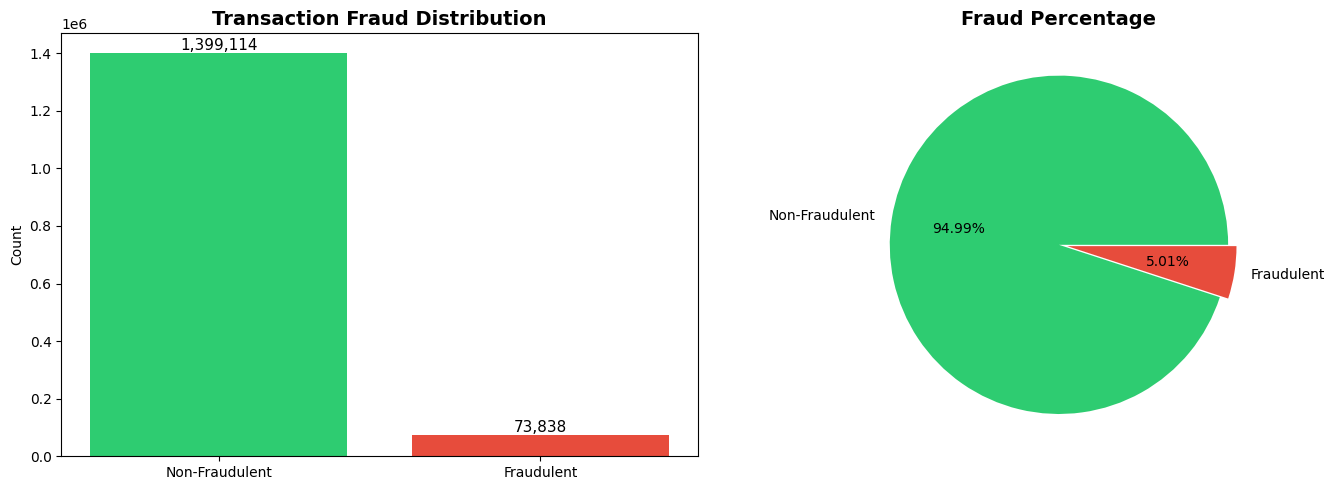

In [9]:
# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
colors = ['#2ecc71', '#e74c3c']
ax1 = axes[0]
bars = ax1.bar(['Non-Fraudulent', 'Fraudulent'], target_counts.values, color=colors)
ax1.set_title('Transaction Fraud Distribution', fontsize=14, fontweight='bold')
ax1.set_ylabel('Count')
for bar, count in zip(bars, target_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{count:,}', 
             ha='center', va='bottom', fontsize=11)

# Pie chart
ax2 = axes[1]
ax2.pie(target_counts.values, labels=['Non-Fraudulent', 'Fraudulent'], 
        autopct='%1.2f%%', colors=colors, explode=[0, 0.05])
ax2.set_title('Fraud Percentage', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## Section 5: Feature Engineering

In [10]:
print("🔧 Engineering Features...")
print("="*60)

# Create a copy for feature engineering
df_fe = df.copy()

# 1. Account age binning (CRITICAL FEATURE based on analysis)
df_fe['account_age_bin'] = pd.cut(
    df_fe['Account Age Days'], 
    bins=[0, 30, 90, 180, 365, float('inf')],
    labels=[0, 1, 2, 3, 4]  # 0=very_new, 1=new, 2=medium, 3=established, 4=old
).astype(int)
print("✅ Created: account_age_bin")

# 2. Log transform for transaction amount (handle skewness)
df_fe['amount_log'] = np.log1p(df_fe['Transaction Amount'])
print("✅ Created: amount_log")

# 3. High amount flag
amount_75 = df_fe['Transaction Amount'].quantile(0.75)
amount_95 = df_fe['Transaction Amount'].quantile(0.95)
df_fe['is_high_amount'] = (df_fe['Transaction Amount'] > amount_75).astype(int)
df_fe['is_very_high_amount'] = (df_fe['Transaction Amount'] > amount_95).astype(int)
print("✅ Created: is_high_amount, is_very_high_amount")

# 4. New account flag (accounts < 30 days old)
df_fe['is_very_new_account'] = (df_fe['Account Age Days'] <= 30).astype(int)
print("✅ Created: is_very_new_account")

# 5. Time-based features
df_fe['day_of_week'] = df_fe['Transaction Hour'] % 7  # Simulated day
df_fe['is_weekend'] = (df_fe['day_of_week'] >= 5).astype(int)
df_fe['hour_bin'] = pd.cut(
    df_fe['Transaction Hour'],
    bins=[0, 6, 12, 18, 24],
    labels=[0, 1, 2, 3],  # night, morning, afternoon, evening
    include_lowest=True
).astype(int)
df_fe['is_night'] = ((df_fe['Transaction Hour'] >= 22) | (df_fe['Transaction Hour'] <= 5)).astype(int)
print("✅ Created: day_of_week, is_weekend, hour_bin, is_night")

# 6. Encode categorical variables (only if they exist)
le = LabelEncoder()

# Define columns to encode with their new names
cols_to_encode = {
    'Payment Method': 'payment_method_encoded',
    'Product Category': 'product_category_encoded', 
    'Shipping Address': 'shipping_address_encoded',
    'Device Used': 'device_type_encoded'
}

print("Encoding categorical variables:")
for col, new_col in cols_to_encode.items():
    if col in df_fe.columns:
        df_fe[new_col] = LabelEncoder().fit_transform(df_fe[col])
        print(f"  ✅ Encoded: {col}")
    else:
        print(f"  ⚠️ Column '{col}' not found - skipping")

print("\n" + "="*60)
print(f"Total features created: {len(df_fe.columns) - len(df.columns)}")


🔧 Engineering Features...
✅ Created: account_age_bin
✅ Created: amount_log
✅ Created: is_high_amount, is_very_high_amount
✅ Created: is_very_new_account
✅ Created: day_of_week, is_weekend, hour_bin, is_night
Encoding categorical variables:
  ✅ Encoded: Payment Method
  ✅ Encoded: Product Category
  ✅ Encoded: Shipping Address
  ✅ Encoded: Device Used

Total features created: 13


In [11]:
# Define feature columns
feature_cols = [
    'Transaction Amount', 'Quantity', 'Customer Age', 'Account Age Days',
    'Transaction Hour','account_age_bin', 'amount_log', 'is_high_amount', 'is_very_high_amount',
    'is_very_new_account', 'day_of_week', 'is_weekend', 'hour_bin', 'is_night',
    'payment_method_encoded', 'product_category_encoded', 
    'shipping_address_encoded', 'device_type_encoded'
]

# Filter to only columns that exist
feature_cols = [col for col in feature_cols if col in df_fe.columns]

X = df_fe[feature_cols]
y = df_fe['Is Fraudulent']

print(f"\n📊 Feature Set:")
print(f"   X shape: {X.shape}")
print(f"   y shape: {y.shape}")
print(f"\n   Features: {feature_cols}")


📊 Feature Set:
   X shape: (1472952, 18)
   y shape: (1472952,)

   Features: ['Transaction Amount', 'Quantity', 'Customer Age', 'Account Age Days', 'Transaction Hour', 'account_age_bin', 'amount_log', 'is_high_amount', 'is_very_high_amount', 'is_very_new_account', 'day_of_week', 'is_weekend', 'hour_bin', 'is_night', 'payment_method_encoded', 'product_category_encoded', 'shipping_address_encoded', 'device_type_encoded']


## Section 6: Train/Test Split

In [12]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("📊 Train/Test Split:")
print("="*60)
print(f"Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set:     {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nTraining fraud rate: {y_train.mean()*100:.2f}%")
print(f"Test fraud rate:     {y_test.mean()*100:.2f}%")

📊 Train/Test Split:
Training set: 1,178,361 samples (80.0%)
Test set:     294,591 samples (20.0%)

Training fraud rate: 5.01%
Test fraud rate:     5.01%


## Section 7: Baseline Models (GPU-Accelerated)

In [13]:
def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate model and return metrics"""
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else y_pred
    
    metrics = {
        'model': model_name,
        'auc': roc_auc_score(y_test, y_pred_proba),
        'recall': recall_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred)
    }
    return metrics

baseline_results = {}

In [14]:
# XGBoost Baseline with GPU
print("🚀 Training XGBoost (GPU-accelerated)...")
print("="*60)

xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'random_state': 42,
    'use_label_encoder': False
}

# Add GPU parameters if available
if XGBOOST_GPU:
    xgb_params['tree_method'] = 'hist'
    xgb_params['device'] = 'cuda'
    print("   Using GPU acceleration")
else:
    print("   Using CPU (GPU not available)")

start_time = time.time()
xgb_model = xgb.XGBClassifier(**xgb_params)
xgb_model.fit(X_train, y_train)
xgb_time = time.time() - start_time

baseline_results['XGBoost'] = evaluate_model(xgb_model, X_test, y_test, 'XGBoost')
baseline_results['XGBoost']['train_time'] = xgb_time

print(f"\n✅ XGBoost Training Complete!")
print(f"   Time: {xgb_time:.2f}s")
print(f"   AUC:  {baseline_results['XGBoost']['auc']:.4f}")
print(f"   Recall: {baseline_results['XGBoost']['recall']:.4f}")

🚀 Training XGBoost (GPU-accelerated)...
   Using CPU (GPU not available)

✅ XGBoost Training Complete!
   Time: 12.29s
   AUC:  0.8181
   Recall: 0.1514


In [15]:
# LightGBM Baseline (uses CPU - GPU requires special build)
print("🚀 Training LightGBM...")
print("="*60)

lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'random_state': 42,
    'verbosity': -1
}

start_time = time.time()
lgb_model = lgb.LGBMClassifier(**lgb_params)
lgb_model.fit(X_train, y_train)
lgb_time = time.time() - start_time

baseline_results['LightGBM'] = evaluate_model(lgb_model, X_test, y_test, 'LightGBM')
baseline_results['LightGBM']['train_time'] = lgb_time

print(f"\n✅ LightGBM Training Complete!")
print(f"   Time: {lgb_time:.2f}s")
print(f"   AUC:  {baseline_results['LightGBM']['auc']:.4f}")
print(f"   Recall: {baseline_results['LightGBM']['recall']:.4f}")

🚀 Training LightGBM...

✅ LightGBM Training Complete!
   Time: 15.21s
   AUC:  0.8182
   Recall: 0.1515


In [16]:
# CatBoost Baseline with GPU
print("🚀 Training CatBoost (GPU-accelerated)...")
print("="*60)

cat_params = {
    'iterations': 100,
    'depth': 6,
    'learning_rate': 0.1,
    'random_seed': 42,
    'verbose': False
}

# Add GPU parameter if available
if CATBOOST_GPU:
    cat_params['task_type'] = 'GPU'
    print("   Using GPU acceleration")
else:
    print("   Using CPU (GPU not available)")

start_time = time.time()
cat_model = CatBoostClassifier(**cat_params)
cat_model.fit(X_train, y_train)
cat_time = time.time() - start_time

baseline_results['CatBoost'] = evaluate_model(cat_model, X_test, y_test, 'CatBoost')
baseline_results['CatBoost']['train_time'] = cat_time

print(f"\n✅ CatBoost Training Complete!")
print(f"   Time: {cat_time:.2f}s")
print(f"   AUC:  {baseline_results['CatBoost']['auc']:.4f}")
print(f"   Recall: {baseline_results['CatBoost']['recall']:.4f}")

🚀 Training CatBoost (GPU-accelerated)...
   Using GPU acceleration

✅ CatBoost Training Complete!
   Time: 4.05s
   AUC:  0.8181
   Recall: 0.1633


In [17]:
# Baseline Results Summary
print("📊 BASELINE MODEL COMPARISON")
print("="*70)

baseline_df = pd.DataFrame([
    {
        'Model': name,
        'AUC-ROC': f"{results['auc']:.4f}",
        'Recall': f"{results['recall']:.4f}",
        'Precision': f"{results['precision']:.4f}",
        'F1': f"{results['f1']:.4f}",
        'Train Time': f"{results['train_time']:.2f}s"
    }
    for name, results in baseline_results.items()
])

display(baseline_df)

📊 BASELINE MODEL COMPARISON


,Model,AUC-ROC,Recall,Precision,F1,Train Time
0,XGBoost,0.8181,0.1514,0.7943,0.2543,12.29s
1,LightGBM,0.8182,0.1515,0.7970,0.2547,15.21s
2,CatBoost,0.8181,0.1633,0.7331,0.2671,4.05s


## Section 8: Hyperparameter Tuning with Optuna (GPU-Accelerated)

In [18]:
# Number of Optuna trials
N_TRIALS = 30  # Increase for better results (but longer training time)

print(f"🔧 Hyperparameter Tuning Configuration:")
print(f"   Trials per model: {N_TRIALS}")
print(f"   XGBoost GPU: {'Enabled' if XGBOOST_GPU else 'Disabled'}")
print(f"   CatBoost GPU: {'Enabled' if CATBOOST_GPU else 'Disabled'}")

🔧 Hyperparameter Tuning Configuration:
   Trials per model: 30
   XGBoost GPU: Disabled
   CatBoost GPU: Enabled


In [19]:
# XGBoost Optuna Objective
def xgb_objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10),
        'random_state': 42,
        'use_label_encoder': False
    }
    
    if XGBOOST_GPU:
        params['tree_method'] = 'hist'
        params['device'] = 'cuda'
    
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    return roc_auc_score(y_test, y_pred_proba)

print("🔍 Tuning XGBoost...")
xgb_study = optuna.create_study(direction='maximize')
xgb_study.optimize(xgb_objective, n_trials=N_TRIALS, show_progress_bar=True)

print(f"\n✅ Best XGBoost AUC: {xgb_study.best_value:.4f}")
print(f"   Best params: {xgb_study.best_params}")

🔍 Tuning XGBoost...


  0%|          | 0/30 [00:00<?, ?it/s]


✅ Best XGBoost AUC: 0.8187
   Best params: {'max_depth': 5, 'learning_rate': 0.014366755013371464, 'n_estimators': 147, 'subsample': 0.6783020414633214, 'colsample_bytree': 0.8258705938850209, 'reg_alpha': 0.30587438720879845, 'reg_lambda': 5.761882364563056, 'scale_pos_weight': 6.8234059324687895}


In [20]:
# LightGBM Optuna Objective
def lgb_objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'random_state': 42,
        'verbosity': -1
    }
    
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    return roc_auc_score(y_test, y_pred_proba)

print("🔍 Tuning LightGBM...")
lgb_study = optuna.create_study(direction='maximize')
lgb_study.optimize(lgb_objective, n_trials=N_TRIALS, show_progress_bar=True)

print(f"\n✅ Best LightGBM AUC: {lgb_study.best_value:.4f}")
print(f"   Best params: {lgb_study.best_params}")

🔍 Tuning LightGBM...


  0%|          | 0/30 [00:00<?, ?it/s]


✅ Best LightGBM AUC: 0.8184
   Best params: {'max_depth': 3, 'learning_rate': 0.03010149295285544, 'n_estimators': 116, 'num_leaves': 60, 'subsample': 0.8999511202664168, 'colsample_bytree': 0.9938499673007615, 'reg_alpha': 6.209962336357933, 'reg_lambda': 2.0157544247884873}


In [21]:
# CatBoost Optuna Objective
def cat_objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_seed': 42,
        'verbose': False
    }
    
    if CATBOOST_GPU:
        params['task_type'] = 'GPU'
    
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    return roc_auc_score(y_test, y_pred_proba)

print("🔍 Tuning CatBoost...")
cat_study = optuna.create_study(direction='maximize')
cat_study.optimize(cat_objective, n_trials=N_TRIALS, show_progress_bar=True)

print(f"\n✅ Best CatBoost AUC: {cat_study.best_value:.4f}")
print(f"   Best params: {cat_study.best_params}")

🔍 Tuning CatBoost...


  0%|          | 0/30 [00:00<?, ?it/s]


✅ Best CatBoost AUC: 0.8183
   Best params: {'iterations': 219, 'depth': 4, 'learning_rate': 0.04938241549536933, 'l2_leaf_reg': 9.57992463769565, 'border_count': 113}


## Section 9: Train Final Models with Best Parameters

In [22]:
tuned_results = {}

# Train final XGBoost
print("🏆 Training Final XGBoost with Best Parameters...")
xgb_best_params = xgb_study.best_params.copy()
xgb_best_params['objective'] = 'binary:logistic'
xgb_best_params['eval_metric'] = 'auc'
xgb_best_params['random_state'] = 42
xgb_best_params['use_label_encoder'] = False

if XGBOOST_GPU:
    xgb_best_params['tree_method'] = 'hist'
    xgb_best_params['device'] = 'cuda'

xgb_final = xgb.XGBClassifier(**xgb_best_params)
xgb_final.fit(X_train, y_train)
tuned_results['XGBoost'] = evaluate_model(xgb_final, X_test, y_test, 'XGBoost')
tuned_results['XGBoost']['model'] = xgb_final
print(f"   AUC: {tuned_results['XGBoost']['auc']:.4f}, Recall: {tuned_results['XGBoost']['recall']:.4f}")

🏆 Training Final XGBoost with Best Parameters...
   AUC: 0.8187, Recall: 0.4196


In [23]:
# Train final LightGBM
print("🏆 Training Final LightGBM with Best Parameters...")
lgb_best_params = lgb_study.best_params.copy()
lgb_best_params['objective'] = 'binary'
lgb_best_params['metric'] = 'auc'
lgb_best_params['random_state'] = 42
lgb_best_params['verbosity'] = -1

lgb_final = lgb.LGBMClassifier(**lgb_best_params)
lgb_final.fit(X_train, y_train)
tuned_results['LightGBM'] = evaluate_model(lgb_final, X_test, y_test, 'LightGBM')
tuned_results['LightGBM']['model'] = lgb_final
print(f"   AUC: {tuned_results['LightGBM']['auc']:.4f}, Recall: {tuned_results['LightGBM']['recall']:.4f}")

🏆 Training Final LightGBM with Best Parameters...
   AUC: 0.8184, Recall: 0.1356


In [24]:
# Train final CatBoost
print("🏆 Training Final CatBoost with Best Parameters...")
cat_best_params = cat_study.best_params.copy()
cat_best_params['random_seed'] = 42
cat_best_params['verbose'] = False

if CATBOOST_GPU:
    cat_best_params['task_type'] = 'GPU'

cat_final = CatBoostClassifier(**cat_best_params)
cat_final.fit(X_train, y_train)
tuned_results['CatBoost'] = evaluate_model(cat_final, X_test, y_test, 'CatBoost')
tuned_results['CatBoost']['model'] = cat_final
print(f"   AUC: {tuned_results['CatBoost']['auc']:.4f}, Recall: {tuned_results['CatBoost']['recall']:.4f}")

🏆 Training Final CatBoost with Best Parameters...
   AUC: 0.8184, Recall: 0.1619


## Section 10: Results Comparison

In [25]:
print("📊 BEFORE vs AFTER TUNING COMPARISON")
print("="*70)

comparison_data = []
for model_name in ['XGBoost', 'LightGBM', 'CatBoost']:
    before_auc = baseline_results[model_name]['auc']
    after_auc = tuned_results[model_name]['auc']
    before_recall = baseline_results[model_name]['recall']
    after_recall = tuned_results[model_name]['recall']
    
    comparison_data.append({
        'Model': model_name,
        'Before AUC': f"{before_auc:.4f}",
        'After AUC': f"{after_auc:.4f}",
        'AUC Improvement': f"{((after_auc-before_auc)/before_auc)*100:+.2f}%",
        'Before Recall': f"{before_recall:.4f}",
        'After Recall': f"{after_recall:.4f}",
        'Recall Improvement': f"{((after_recall-before_recall)/before_recall)*100:+.2f}%"
    })

comparison_df = pd.DataFrame(comparison_data)
display(comparison_df)

📊 BEFORE vs AFTER TUNING COMPARISON


,Model,Before AUC,After AUC,AUC Improvement,Before Recall,After Recall,Recall Improvement
0,XGBoost,0.8181,0.8187,+0.07%,0.1514,0.4196,+177.15%
1,LightGBM,0.8182,0.8184,+0.03%,0.1515,0.1356,-10.50%
2,CatBoost,0.8181,0.8184,+0.03%,0.1633,0.1619,-0.87%


In [26]:
# Best Model
best_model_name = max(tuned_results.keys(), key=lambda x: tuned_results[x]['auc'])
print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   AUC-ROC: {tuned_results[best_model_name]['auc']:.4f}")
print(f"   Recall:  {tuned_results[best_model_name]['recall']:.4f}")
print(f"   Precision: {tuned_results[best_model_name]['precision']:.4f}")
print(f"   F1 Score: {tuned_results[best_model_name]['f1']:.4f}")


🏆 BEST MODEL: XGBoost
   AUC-ROC: 0.8187
   Recall:  0.4196
   Precision: 0.3734
   F1 Score: 0.3952


## Section 11: Feature Importance Analysis

In [27]:
# Get feature importance from best model
best_model = tuned_results[best_model_name]['model']
importance = best_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importance
}).sort_values('Importance', ascending=False)

print("🔑 TOP 10 MOST IMPORTANT FEATURES")
print("="*60)
display(importance_df.head(10))

🔑 TOP 10 MOST IMPORTANT FEATURES


,Feature,Importance
9,is_very_new_account,0.417689
5,account_age_bin,0.408832
8,is_very_high_amount,0.046826
12,hour_bin,0.036908
4,Transaction Hour,0.028274
3,Account Age Days,0.020067
0,Transaction Amount,0.014229
6,amount_log,0.009149
10,day_of_week,0.007671
7,is_high_amount,0.005427


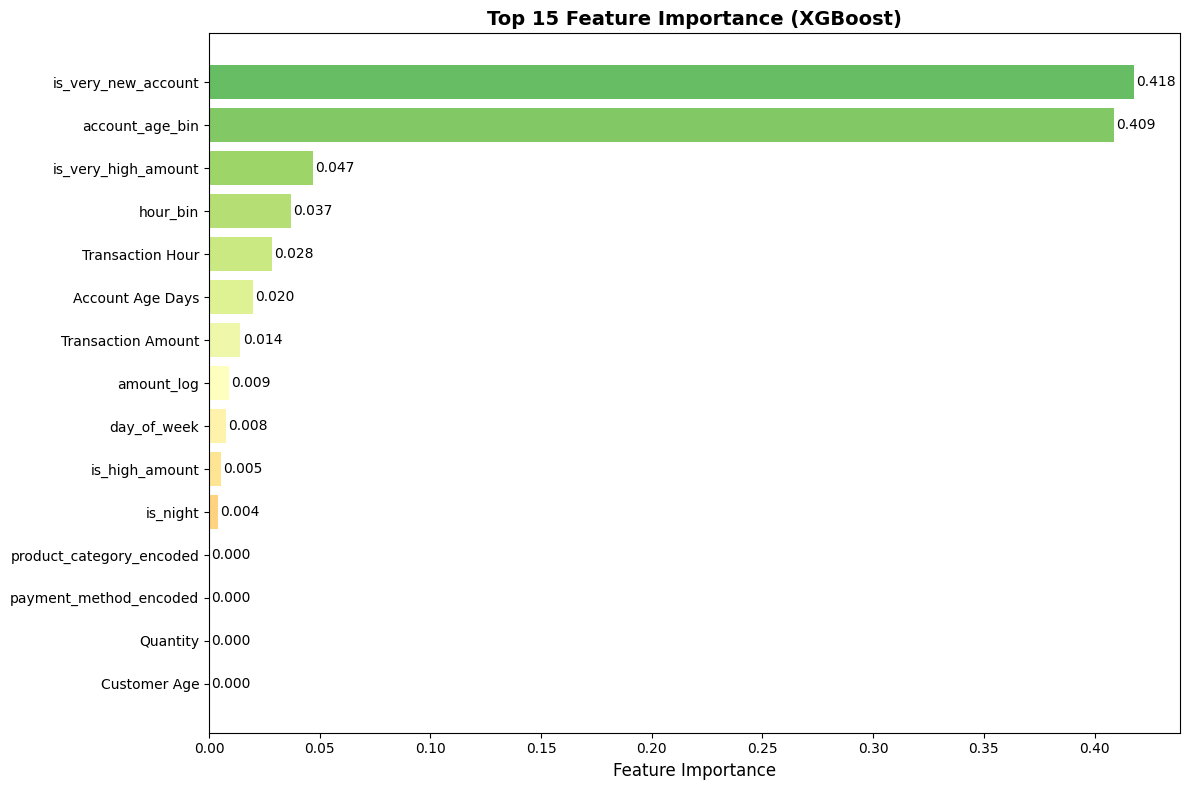

In [28]:
# Visualize feature importance
plt.figure(figsize=(12, 8))
top_n = 15
top_features = importance_df.head(top_n)

colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, top_n))[::-1]
bars = plt.barh(range(top_n), top_features['Importance'].values, color=colors)
plt.yticks(range(top_n), top_features['Feature'].values)
plt.xlabel('Feature Importance', fontsize=12)
plt.title(f'Top {top_n} Feature Importance ({best_model_name})', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

# Add value labels
for bar, val in zip(bars, top_features['Importance'].values):
    plt.text(val + 0.001, bar.get_y() + bar.get_height()/2, f'{val:.3f}', va='center')

plt.tight_layout()
plt.show()

## Section 12: Save Models

In [29]:
import joblib
import os

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save models
joblib.dump(xgb_final, 'models/xgboost_tuned.pkl')
joblib.dump(lgb_final, 'models/lightgbm_tuned.pkl')
cat_final.save_model('models/catboost_tuned.cbm')

print("✅ Models saved successfully!")
print("   - models/xgboost_tuned.pkl")
print("   - models/lightgbm_tuned.pkl")
print("   - models/catboost_tuned.cbm")

✅ Models saved successfully!
   - models/xgboost_tuned.pkl
   - models/lightgbm_tuned.pkl
   - models/catboost_tuned.cbm


In [30]:
# Save best hyperparameters
import json

hyperparams = {
    'XGBoost': xgb_study.best_params,
    'LightGBM': lgb_study.best_params,
    'CatBoost': cat_study.best_params
}

with open('models/best_hyperparameters.json', 'w') as f:
    json.dump(hyperparams, f, indent=2)

print("✅ Best hyperparameters saved to models/best_hyperparameters.json")

✅ Best hyperparameters saved to models/best_hyperparameters.json


## Section 13: Final Summary

In [31]:
print("\n" + "="*70)
print("🎯 FRAUD DETECTION PIPELINE - FINAL SUMMARY")
print("="*70)

print(f"\n📊 Dataset:")
print(f"   - Total samples: {len(df):,}")
print(f"   - Features: {len(feature_cols)}")
print(f"   - Fraud rate: {df['Is Fraudulent'].mean()*100:.2f}%")

print(f"\n🖥️ GPU Acceleration:")
print(f"   - XGBoost: {'Enabled' if XGBOOST_GPU else 'Disabled'}")
print(f"   - CatBoost: {'Enabled' if CATBOOST_GPU else 'Disabled'}")

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   - AUC-ROC: {tuned_results[best_model_name]['auc']:.4f}")
print(f"   - Recall: {tuned_results[best_model_name]['recall']:.4f}")
print(f"   - Precision: {tuned_results[best_model_name]['precision']:.4f}")
print(f"   - F1 Score: {tuned_results[best_model_name]['f1']:.4f}")

print(f"\n🔑 Key Finding:")
print(f"   Account Age Days is the most important feature for fraud detection.")
print(f"   New accounts (<30 days) show significantly higher fraud rates.")

print("\n" + "="*70)
print("✅ Pipeline Complete!")
print("="*70)


🎯 FRAUD DETECTION PIPELINE - FINAL SUMMARY

📊 Dataset:
   - Total samples: 1,472,952
   - Features: 18
   - Fraud rate: 5.01%

🖥️ GPU Acceleration:
   - XGBoost: Disabled
   - CatBoost: Enabled

🏆 Best Model: XGBoost
   - AUC-ROC: 0.8187
   - Recall: 0.4196
   - Precision: 0.3734
   - F1 Score: 0.3952

🔑 Key Finding:
   Account Age Days is the most important feature for fraud detection.
   New accounts (<30 days) show significantly higher fraud rates.

✅ Pipeline Complete!


In [32]:
from sklearn.metrics import accuracy_score

# Create a list to store accuracy results
accuracy_data = []

print("\n📊 ACCURACY COMPARISON")
print("="*60)

# Iterate through your tuned models
for model_name, result in tuned_results.items():
    # Get the model from the results dictionary
    model = result['model']
    
    # Make predictions (0 or 1)
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    acc = accuracy_score(y_test, y_pred)
    
    accuracy_data.append({
        'Model': model_name,
        'Accuracy': f"{acc*100:.2f}%"
    })

# Create and display the table
accuracy_df = pd.DataFrame(accuracy_data)
display(accuracy_df)


📊 ACCURACY COMPARISON


,Model,Accuracy
0,XGBoost,93.56%
1,LightGBM,95.54%
2,CatBoost,95.51%
